# Configuration & Imports

In [38]:
!pip install fvcore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import sys
import torch


pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py37_cu113_pyt1121/download.html


In [40]:
!pip install SimpleITK --only-binary :all: 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [305]:
import os
import json
import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Union, Tuple, List
from scipy.ndimage import interpolation, zoom
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import pytorch3d
import pytorch3d.transforms as t

import torch
import torch.nn as nn

In [ ]:
from google.colab import drive


drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%rm -rf ./sample_data
%mkdir aidiagnostic_-_cv
%mkdir aidiagnostic_-_cv/data
%cd aidiagnostic_-_cv/data

/content/aidiagnostic_-_cv/data


Загружаем исходные данные

In [ ]:
%cp "../../drive/MyDrive/Colab Notebooks/data/subset.zip" ./
!unzip subset.zip
%rm subset.zip
%cd ../

Archive:  subset.zip
  inflating: metadata.json           
   creating: subset/
   creating: subset/subset_img/
   creating: subset/subset_img/LUNG1-001/
   creating: subset/subset_img/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/
   creating: subset/subset_img/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/09-18-2008/
   creating: subset/subset_img/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/09-18-2008/.ipynb_checkpoints/
  inflating: subset/subset_img/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/09-18-2008/.ipynb_checkpoints/1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046-checkpoint.json  
   creating: subset/subset_img/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/09-18-2008/1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046/
  inflating: subset/subset_img/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597

In [82]:
%ls

data/


# Data augmentation

Load the input data

In [145]:
def load_dicom(directory: str) -> np.array:
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image_itk = reader.Execute()

    image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
    return image_zyx


# read metadata from file
with open("./data/metadata.json", "r") as json_file:
    metadata = json.load(json_file)
    metadata = {int(k): v for k, v in metadata.items()}

lung_num = 24

# read image
img = load_dicom(directory=metadata[lung_num]["img"].replace("\\", "/"))
print(type(img), img.shape)

# read mask
mask = nib.load(metadata[lung_num]["mask"].replace("\\", "/"))
mask = np.rot90(mask.get_fdata().transpose(2, 0, 1), axes=(1, 2))
print(type(mask), mask.shape)

<class 'numpy.ndarray'> (95, 512, 512)
<class 'numpy.ndarray'> (95, 512, 512)


## 3d tensor rotaion

In [311]:
def rotate_data(mask:np.array, image: np.array, angle: int, axs: Tuple[int, int], 
                mask_params: dict = dict(
                    order=1,
                    mode="constant", 
                    cval=0.0, 
                    reshape=False),
                image_params: dict = dict(
                    order=1,
                    mode="constant", 
                    cval=0.0, 
                    reshape=False)):
  rotated_mask = interpolation.rotate(mask, angle=angle, axes=axs, **mask_params)
  rotated_mask = (~np.isclose(rotated_mask, np.zeros_like(rotated_mask))).astype("float")
  rotated_img = interpolation.rotate(img, angle=angle, axes=axs, **image_params)
  return rotated_mask, rotated_img


def plot_(mask: np.array, image: np.array, ax, title: str = "Initial"):
  ax.imshow(image, cmap="gray")
  ax.imshow(np.ma.masked_where(mask == 0, mask), 
            cmap=ListedColormap(np.array([cm.get_cmap("viridis", 256)(0.98)])), 
            interpolation='none', alpha=0.3)
  ax.set_title(label=title)
  ax.grid("off")
  ax.axis("off")
  return


def plot(mask: np.array, image: np.array, slice_idx: int, angle: int, axs: Tuple[int, int], 
         mask_params: dict = dict(
             order=1,
             mode="constant", 
             cval=0.0, 
             reshape=False),
         image_params: dict = dict(
             order=1,
             mode="constant", 
             cval=0.0, 
             reshape=False)):
  rotated_mask, rotated_img = rotate_data(mask=mask, image=image, angle=angle, axs=axs, 
                                          mask_params=mask_params, image_params=image_params)

  fig = plt.figure(figsize=(16, 8))
  ax_initial, ax_rotated = fig.add_subplot(121), fig.add_subplot(122)
  plot_(mask=mask[slice_idx, :, :], image=image[slice_idx, :, :], ax=ax_initial)
  plot_(mask=rotated_mask[slice_idx, :, :], image=rotated_img[slice_idx, :, :], ax=ax_rotated, 
        title="Rotated")
  return

### Image + Mask rotation (around 0)

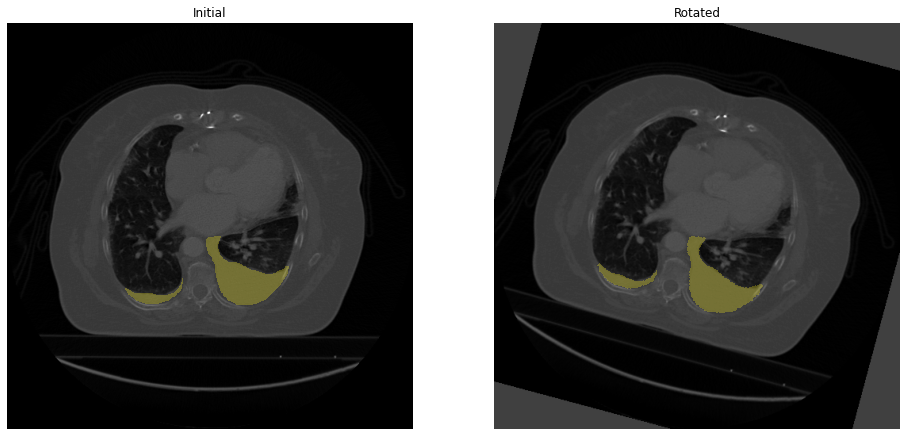

In [315]:
plot(mask=mask, image=img, slice_idx=30, angle=-15, axs=(1, 2))

### Image + Mask rotation (around 1)

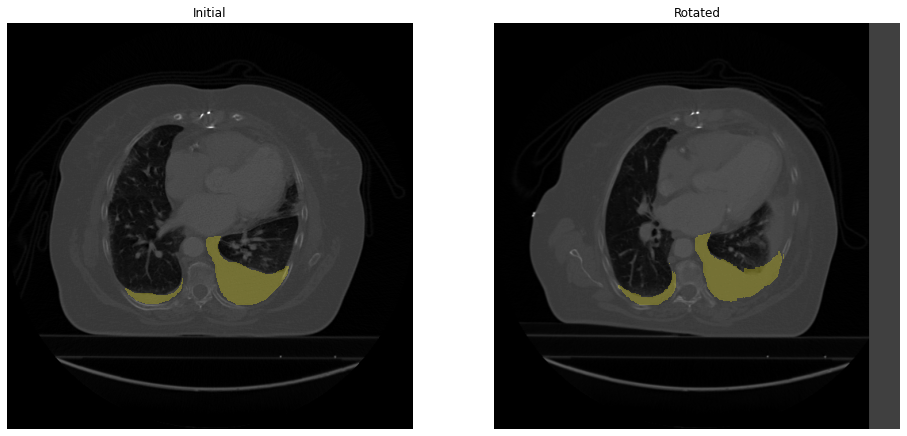

In [314]:
plot(mask=mask, image=img, slice_idx=30, angle=-8, axs=(0, 2))

## Image + Mask rotation (around 2)

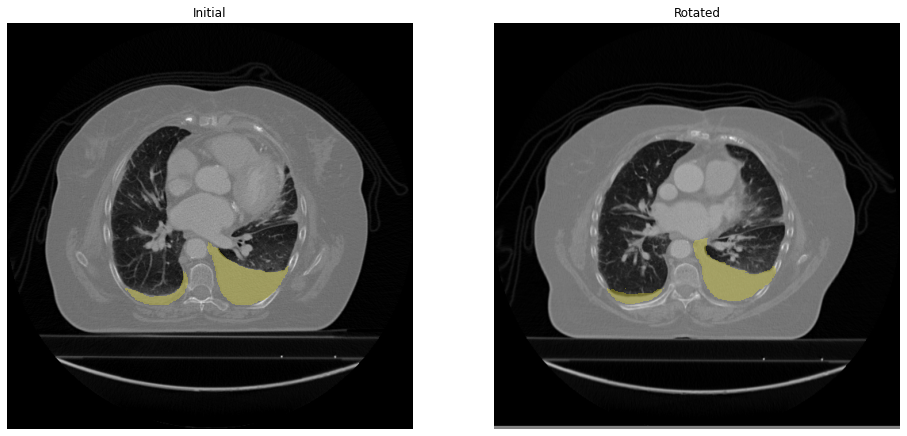

In [313]:
plot(mask=mask, image=img, slice_idx=35, angle=-8, axs=(0, 1))